In [415]:
import numpy as np
from matplotlib import pyplot as plt
from torch import nn
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
%matplotlib inline

## Raw implementation of NN in numpy

In [302]:
# BP thinking - for any equation, the gradient of inputs is product of gradients of
# the loss with respect to output (how the loss changes with respect to output)
# the output with respect to inputs (hot the output changes with respect to inputs)

# Nice videos for vectorizing code
# https://www.youtube.com/watch?v=-l9BdZsopYI

class Linear:
    def __init__(self, input_dim, output_dim):
        # output dim is k, input dim is d
        self.W = np.random.randn(output_dim,input_dim) *0.01# kxd matrix
        self.b = np.random.randn(output_dim,1) *0.01 # kx1 matrix
        self.gradW = np.random.randn(output_dim,input_dim) # kxd matrix
        self.gradb = np.random.randn(output_dim)
        
    # x is 1xd single example
    def forward(self, x):
        # z = XWT + b
        output = np.dot(self.W,x) + self.b
        return output # nxk matrix
    
    def backward(self, x, prevGrad):
        # this can be thought as three separate groups of variables in computation graph
        # 1. the inputs x
        # 2. the weights w
        # 3. the bias b
        # z = XWT + b
        
        # dL/dW = dz/dW * dL/dz
        # this is a kxd matrix
        self.gradW = np.dot(prevGrad, x.T)
        
        # dL/db = dz/db * dL/dz
        # this is a kx1 matrix
        self.gradb = np.copy(prevGrad)
        
        # this needs to be returned; as this is the value comes from previous layer
        # dL/dX = dz/dX * dL/dz
        # this is a dx1 matrix
        return np.dot(self.W.T ,prevGrad)
        
        
class Sigmoid:
    def __init__(self):
        pass
    
    def forward(self, x):
        output = 1/(1+np.exp(-x))
        return output
    
    def backward(self, x, prevGrad):
        sig = 1/(1+np.exp(-x))
        return np.multiply(np.multiply(sig, (1 - sig)), prevGrad)
        
class MSE:
    def __init__(self):
        pass
    
    def forward(self,prediction, label):
        output = np.mean(np.square((prediction-label)))
        return output
    
    def backward(self, prediction, label):
        return np.mean(2*(prediction - label))
        
        

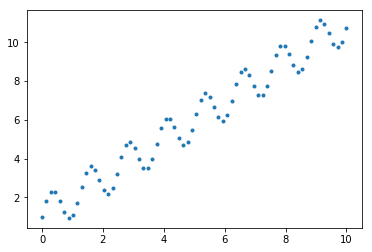

In [303]:
def createData():
    x = np.linspace(0,10,70)
    y = np.sin(5*x) + np.random.randn()*5 + x
    return (x,y)
## Create data
# X is 1xd thing
(X,y) = createData()
plt.plot(X,y,'.')

In [307]:
n = len(X)
d = 1
o = 1
h = 3

Xi = X[1]
yi = y[1]
lin1 = Linear(d,h)
sig = Sigmoid()
lin2 = Linear(h,o)
mse = MSE()

z = lin1.forward(Xi) # kx1 matrix
a = sig.forward(z)
yhat = lin2.forward(a)
loss = mse.forward(yhat,yi)

grad1 = mse.backward(yhat,yi)
grad2 = lin2.backward(a, grad1)
grad3 = sig.backward(z, grad2)
grad4 = lin1.backward(Xi, grad3)

In [308]:
display(lin1.gradb)
display(lin1.gradW)

array([[ 0.0029194 ],
       [ 0.00149857],
       [ 0.01011252]])

array([[ 0.0004231 ],
       [ 0.00021718],
       [ 0.00146558]])

In [ ]:
ep = 0.00001
for i in range (0, lin1.gradW.shape[0]):
    for j in range(0, lin2.gradW.shape[1]):
        loss = mse.forward(lin2.forward(a = sig.forward(lin1.forward(Xi))))
        new_weight = np.copy(lin1.we)


## Stochatic gradient

Iteration 0 = 0.627220
Iteration 50 = 1.707527
Iteration 100 = 1.404327
Iteration 150 = 1.132808
Iteration 200 = 0.904998
Iteration 250 = 0.733552
Iteration 300 = 0.619262
Iteration 350 = 0.551203
Iteration 400 = 0.514249
Iteration 450 = 0.495494
Iteration 500 = 0.486373
Iteration 550 = 0.482028
Iteration 600 = 0.479964
Iteration 650 = 0.478973
Iteration 700 = 0.478488
Iteration 750 = 0.478247
Iteration 800 = 0.478128
Iteration 850 = 0.478073
Iteration 900 = 0.478051
Iteration 950 = 0.478049


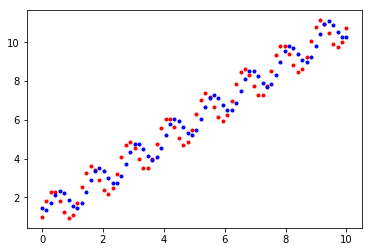

In [371]:
alpha = 0.0001
epochs = 1000

h=10000
lin1 = Linear(d,h)
sig = Sigmoid()
lin2 = Linear(h,o)
mse = MSE()

for epoch in range(0,epochs):
    loss = 0
    Yhat = np.zeros(n)
    for i in range(0, n):
        Xi = X[i]
        yi = y[i]

        # forward propagation
        z = lin1.forward(Xi)
        a = sig.forward(z)
        yhat = lin2.forward(a)
        loss += mse.forward(yhat,yi)
        Yhat[i] = yhat
        
        grad1 = mse.backward(yhat,yi)
        grad2 = lin2.backward(a, grad1)
        grad3 = sig.backward(z, grad2)
        grad4 = lin1.backward(Xi, grad3)
        
        lin1.W = lin1.W - alpha*lin1.gradW
        lin1.b = lin1.b - alpha*lin1.gradb
        lin2.W = lin2.W - alpha*lin2.gradW
        lin2.b = lin2.b - alpha*lin2.gradb

    if epoch % 50 == 0:
        print('Iteration %d = %.6f' % (epoch, loss / n))        
        
plt.plot(X,y,'.r')
plt.plot(X,Yhat,'.b')

Sigmoid does not give a good solution with less nunmber of units.
Also, notice how it cheated the loss by predicting +ve and -ve losses.
Even I use more number of layers, i can improve a bit.

In [338]:
# Rectified linear unit
class ReLU:
    def forward(self, x):
        return np.multiply(np.greater(x,0),x)
    
    def backward(self, x, prevGrad):
        inter = np.greater(x,0).astype(float)
        return np.multiply(inter, prevGrad)
        
# Hyperbolic tangent.
class Tanh:
    def forward(self, x):
        a = np.exp(x)
        b = np.exp(-x)
        tanh = (a-b)/(a+b)
        return tanh
    
    def backward(self, x, prevGrad):
        a = np.exp(x)
        b = np.exp(-x)
        tanh = (a-b)/(a+b)
        return np.multiply((1-np.square(tanh)), prevGrad)

Iteration 0 = 5.066288
Iteration 50 = 1.845312
Iteration 100 = 0.530817
Iteration 150 = 0.376960
Iteration 200 = 0.376253
Iteration 250 = 0.375795
Iteration 300 = 0.374820
Iteration 350 = 0.373465


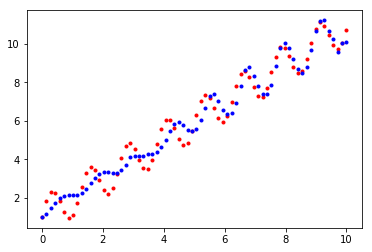

In [364]:
alpha = 0.01
epochs = 400

h=5
lin1 = Linear(d,h)
sig = ReLU()
lin2 = Linear(h,o)
mse = MSE()

for epoch in range(0,epochs):
    loss = 0
    Yhat = np.zeros(n)
    for i in range(0, n):
        Xi = X[i]
        yi = y[i]

        # forward propagation
        z = lin1.forward(Xi)
        a = sig.forward(z)
        yhat = lin2.forward(a)
        loss += mse.forward(yhat,yi)
        Yhat[i] = yhat
        
        grad1 = mse.backward(yhat,yi)
        grad2 = lin2.backward(a, grad1)
        grad3 = sig.backward(z, grad2)
        grad4 = lin1.backward(Xi, grad3)
        
        lin1.W = lin1.W - alpha*lin1.gradW
        lin1.b = lin1.b - alpha*lin1.gradb
        lin2.W = lin2.W - alpha*lin2.gradW
        lin2.b = lin2.b - alpha*lin2.gradb

    if epoch % 50 == 0:
        print('Iteration %d = %.6f' % (epoch, loss / n))        
        
plt.plot(X,y,'.r')
plt.plot(X,Yhat,'.b')

Relu gives an okayish solution even with less number of layers
Seems like its learning the up and downward lines


Iteration 0 = 2.630389
Iteration 50 = 0.419176
Iteration 100 = 0.426562
Iteration 150 = 0.433610
Iteration 200 = 0.441109
Iteration 250 = 0.448841
Iteration 300 = 0.455971
Iteration 350 = 0.462215


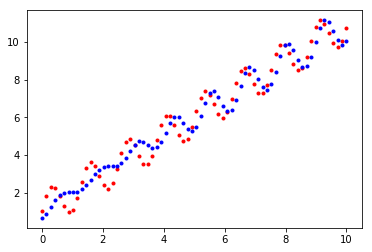

In [366]:
# Relu gives an okayish solution even with less number of layers
# seems like its learning the up and downward lines

alpha = 0.01
epochs = 400

h=50
lin1 = Linear(d,h)
sig = Tanh()
lin2 = Linear(h,o)
mse = MSE()

for epoch in range(0,epochs):
    loss = 0
    Yhat = np.zeros(n)
    for i in range(0, n):
        Xi = X[i]
        yi = y[i]

        # forward propagation
        z = lin1.forward(Xi)
        a = sig.forward(z)
        yhat = lin2.forward(a)
        loss += mse.forward(yhat,yi)
        Yhat[i] = yhat
        
        grad1 = mse.backward(yhat,yi)
        grad2 = lin2.backward(a, grad1)
        grad3 = sig.backward(z, grad2)
        grad4 = lin1.backward(Xi, grad3)
        
        lin1.W = lin1.W - alpha*lin1.gradW
        lin1.b = lin1.b - alpha*lin1.gradb
        lin2.W = lin2.W - alpha*lin2.gradW
        lin2.b = lin2.b - alpha*lin2.gradb

    if epoch % 50 == 0:
        print('Iteration %d = %.6f' % (epoch, loss / n))        
        
plt.plot(X,y,'.r')
plt.plot(X,Yhat,'.b')

TanH has similar to relu behavior, makes sense

## Using pytorch

In [433]:
class Net(nn.Module):
    def __init__(self, hidden):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, hidden)
        self.fc2 = nn.Linear(hidden,1)
        
    def forward(self,x):
        z = self.fc1(x)
        a = F.sigmoid(z)
        yhat = self.fc2(a)
        return yhat

Epoch [0]: loss = 47.200035
Epoch [10000]: loss = 0.412635
Epoch [20000]: loss = 0.207668
Epoch [30000]: loss = 0.147588
Epoch [40000]: loss = 0.133015
Epoch [50000]: loss = 0.118666
Epoch [60000]: loss = 0.099852
Epoch [70000]: loss = 0.066810
Epoch [80000]: loss = 0.038356
Epoch [90000]: loss = 0.030612
Epoch [100000]: loss = 0.024403
Epoch [110000]: loss = 0.022680
Epoch [120000]: loss = 0.021205
Epoch [130000]: loss = 0.020583
Epoch [140000]: loss = 0.021146


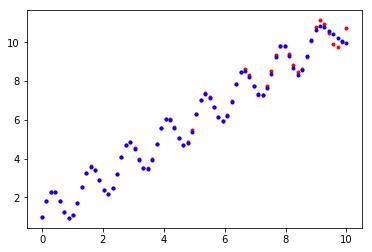

In [505]:
net = Net(20)
net.train()
if torch.cuda.is_available():
    net = net.cuda()
criterion = nn.MSELoss()

tensorX = torch.FloatTensor(X)
tensorX = tensorX.unsqueeze(1)
varX = Variable(tensorX)    
varY = Variable(torch.FloatTensor(y).unsqueeze(1))

optimizer = optim.Adam(net.parameters(), lr=0.01)
for epoch in range(0,150000):    
    yhat = net(varX)
    loss = criterion(yhat, varY)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch%10000 ==0:
        print("Epoch [%d]: loss = %.6f" % (epoch, loss))
    
#Print paramters for diagnosis
# for paramter in net.named_parameters():
#     print paramter    

plt.plot(X,y,'.r')
plt.plot(X,yhat.data.squeeze().numpy(),'.b')

Pytorch batching is very fast and hence allows a lot of epochs quickly!
Also adam is kind of cool and better than sgd